In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns 
from matplotlib import pyplot as plt
import hashlib
import tensorflow as tf

from bias_detection.bias_tree import BiasDetectionTree, get_metric_bias_tree_for_model, evaluate_model
from data_preparation.movielens import MovieLens100KData, MovieLens1MData
from data_preparation.marketing_bias import MarketBiasModCloth, MarketBiasElectronics
from data_preparation.book_crossing import BookCrossingData
from data_preparation.deskdrop import DeskdropData
from recommender.factorization_recommender import fit_recommendation_model, retrain_recommendation_model,\
tune_recommendation_hyperparams, BiasEvaluationCallback

### Analyze minimum and maximum biased nodes during training

In [62]:
NUM_EPOCH = 20
BATCH_SIZE = 128
EMBEDDING_SIZE = 64
min_user_interactions = 10
shuffle = True

ModCloth
Epoch 1/20
183/183 [==============================] - 1s 2ms/step - loss: 13.6430
Epoch 2/20
183/183 [==============================] - 0s 2ms/step - loss: 1.2463
Epoch 3/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0585
Epoch 4/20
183/183 [==============================] - 0s 3ms/step - loss: 1.0509
Epoch 5/20
183/183 [==============================] - 0s 2ms/step - loss: 1.0610
Epoch 6/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0452
Epoch 7/20
183/183 [==============================] - 0s 2ms/step - loss: 1.0570
Epoch 8/20
183/183 [==============================] - 0s 2ms/step - loss: 1.0544
Epoch 9/20
183/183 [==============================] - 0s 2ms/step - loss: 1.0432
Epoch 10/20
183/183 [==============================] - 0s 3ms/step - loss: 1.0264
Epoch 11/20
183/183 [==============================] - 1s 3ms/step - loss: 1.0376
Epoch 12/20
183/183 [==============================] - 0s 2ms/step - loss: 1.0496A: 0s - loss:
Ep

ValueError: left cannot be >= right

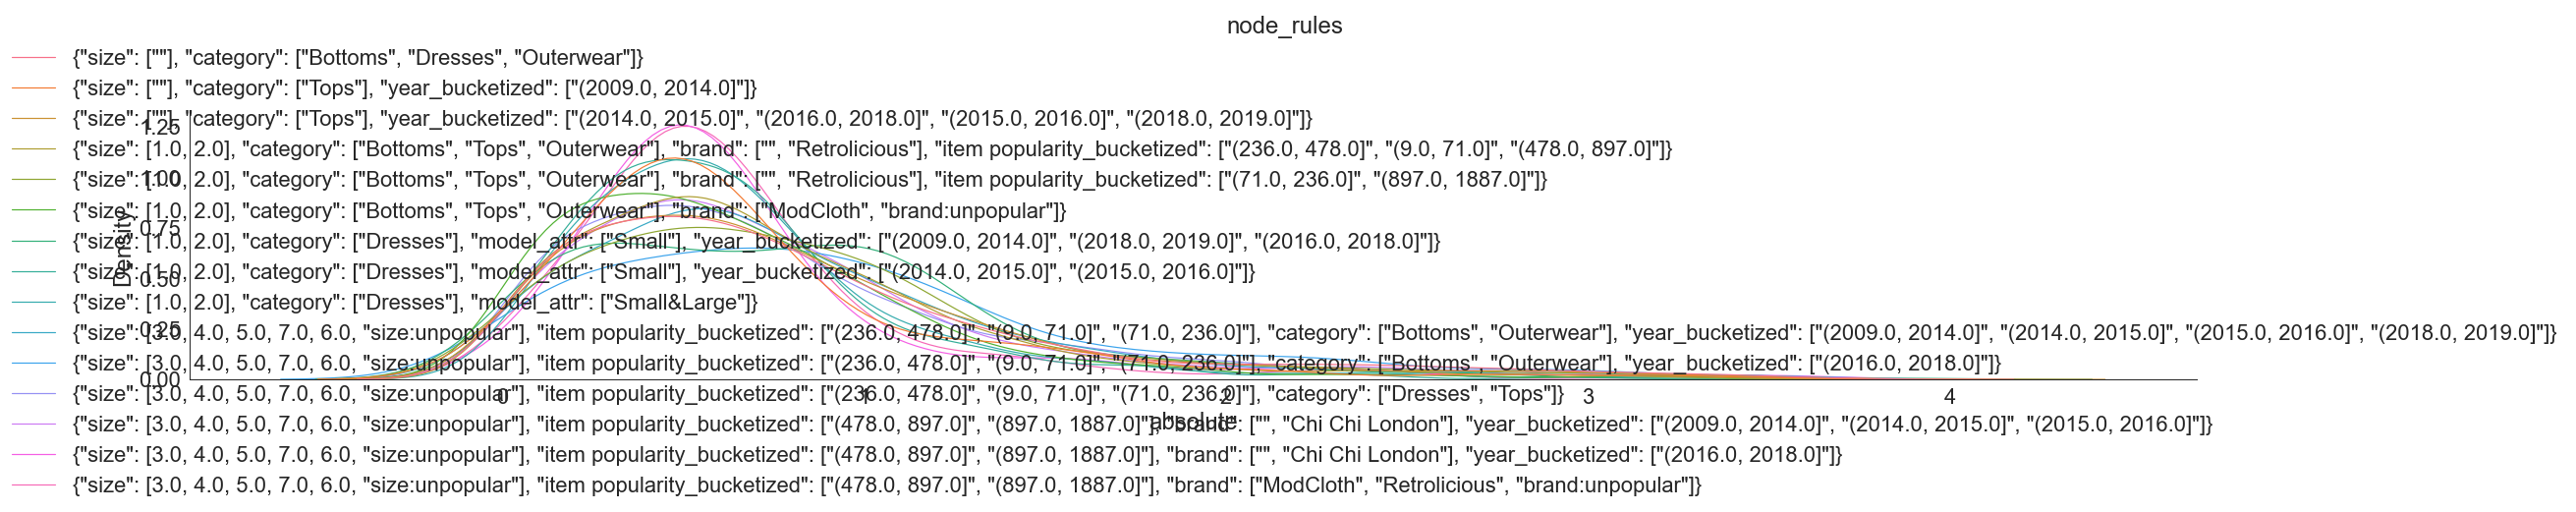

In [63]:
datasets = [MarketBiasModCloth('data/market-bias', min_user_interactions=min_user_interactions),
            MarketBiasElectronics('data/market-bias', min_user_interactions=min_user_interactions),
            MovieLens100KData(data_path='data/ml-100k'), 
            MovieLens1MData('data/ml-1M', min_user_interactions=min_user_interactions),
            BookCrossingData(data_path='data/book-crossing', min_user_interactions=min_user_interactions)]
bias_results = []
min_max_nodes = []
    
for data in datasets:
    print('========================================')
    print(data.NAME)
    X_train, X_test = data.get_data_splits_for_training(shuffle=shuffle, use_val_set=False)
    model, history =  fit_recommendation_model(X_train, user_ids=data.user_ids, item_ids=data.item_ids, 
                                             batch_size=BATCH_SIZE, epochs=NUM_EPOCH, metric=tf.keras.losses.MeanSquaredError(),
                                               embedding_size=EMBEDDING_SIZE, rating_col=data.RATING_COL, 
                                               regularization_coef=1e-6,
                                               user_col=data.USER_ID_COL_TRANSFORMED, item_col=data.ITEM_ID_COL_TRANSFORMED)

    splits = {"train": X_train, "test": X_test}
    metrics = ["absolute", "value", "overestimation", "underestimation"]


    for split in splits:
        print('------------')
        for metric in metrics:
            print(split, metric)
            split_data = splits[split]
            min_node_size = round(0.01 * split_data.shape[0])
            print("min_node_size: ", min_node_size)
            bias_tree = get_metric_bias_tree_for_model(model, split_data, data.attributes_dict, metric_name=metric,
                                                       min_child_node_size=min_node_size, rating_col=data.RATING_COL, 
                                                       user_col=data.USER_ID_COL_TRANSFORMED,  alpha=0.01,
                                                   item_col=data.ITEM_ID_COL_TRANSFORMED, max_depth=5, 
                                                       dataset_name=f'{data.NAME}-{split}', plot_bias_tree=True)
            bias_tree.leaf_metrics["split"] = split
            bias_tree.leaf_metrics["metric"] = metric
            bias_tree.leaf_metrics["dataset"] = data.NAME
            bias_tree.leaf_metrics["level"] = "L5"
            bias_results.append(bias_tree.leaf_metrics)
            min_max_nodes.append({"split": split, "metric": metric,
                                  "min_node": bias_tree.min_metric_node, "min_value": bias_tree.min_metric_value,
                                  "max_node": bias_tree.max_metric_node, "max_value": bias_tree.max_metric_value,
                                 "dataset": data.NAME})




In [4]:
pd.concat(bias_results).to_excel('bias_results-market.xls')

In [5]:
min_max_nodes_pd = pd.DataFrame(min_max_nodes)
min_max_nodes_pd['unfairness'] = abs(min_max_nodes_pd['max_value'] - min_max_nodes_pd['min_value']) #/ min_max_nodes_pd['max_value']
min_max_nodes_pd.to_excel('minmax-market.xls')

In [7]:
pd.set_option('display.max_colwidth', 500)

min_max_nodes_pd[min_max_nodes_pd['metric']=='absolute'][['dataset', 'split', 'min_node', 'min_value', 'max_node', 'max_value']].round(3)

,dataset,split,min_node,min_value,max_node,max_value
0,ModCloth,train,"{""size"": [1.0, 2.0], ""category"": [""Bottoms"", ""Outerwear"", ""Tops""], ""item popularity_bucketized"": [""(236.0, 478.0]"", ""(897.0, 1887.0]"", ""(478.0, 897.0]""], ""brand"": [""ModCloth"", ""brand:unpopular""]}",0.636,"{""size"": [1.0, 2.0], ""category"": [""Dresses""], ""year_bucketized"": [""(2009.0, 2014.0]"", ""(2018.0, 2019.0]""], ""model_attr"": [""Small""]}",0.940
4,ModCloth,test,"{""size"": [1.0, 3.0, 5.0, 2.0], ""year_bucketized"": [""(2009.0, 2014.0]""]}",0.788,"{""size"": ["""", 4.0, 6.0, 7.0, ""size:unpopular""], ""model_attr"": [""Small""], ""user activity_bucketized"": [""(9.0, 18.0]""]}",0.944
8,Electronics,train,"{""year_bucketized"": [""(1998.0, 2011.0]""], ""category"": [""category:unpopular""], ""item popularity_bucketized"": [""(149.0, 355.0]"", ""(9.0, 50.0]""]}",0.174,"{""year_bucketized"": [""(1998.0, 2011.0]""], ""category"": [""Computers & Accessories"", ""Headphones""], ""model_attr"": [""Female"", ""Female&Male""]}",0.391
12,Electronics,test,"{""item popularity_bucketized"": [""(1007.0, 28530.0]"", ""(355.0, 1007.0]"", ""(9.0, 50.0]""]}",0.875,"{""item popularity_bucketized"": [""(149.0, 355.0]"", ""(50.0, 149.0]""]}",0.914


#### Calculate total unfairness

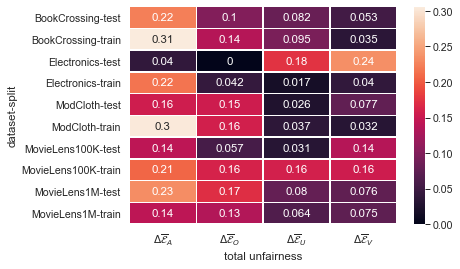

In [16]:
min_max_nodes_pd = pd.read_excel('results/minmax.xls')
sns.set(style="whitegrid", context="paper", font_scale=1.2)
sns.set_context(rc = {'patch.linewidth': 1})
unfairness_notation = "$\Delta\overline{\mathcal{E}}$"

min_max_nodes_pd['total unfairness'] = min_max_nodes_pd['metric'].apply(lambda x:unfairness_notation + "$_{}$".format(x[0].upper()))
plt.tight_layout()

g = sns.heatmap(min_max_nodes_pd.pivot_table(columns='total unfairness', index=['dataset','split'], values='unfairness'),
            annot=True, 
            linewidths=.5)
g.figure.savefig("unfairness_heatmap.png", dpi=600, bbox_inches='tight')

#### Print global results

In [28]:
bias_results_pd = pd.read_excel('results/bias_results.xls')
bias_results_pd_pivot = bias_results_pd[bias_results_pd['level']=='L5'].pivot_table(columns=['split'],
                                  index=['dataset','metric'], 
                                  values=['mean'], 
                                  aggfunc=['count', 'min', 'max']).round(3)

In [54]:
results_global = bias_results_pd[bias_results_pd['level']=='L5'].groupby(['dataset','metric', 'split']).mean()['global'].to_frame().pivot_table(columns=['split'],
                                  index=['dataset','metric'])
print(results_global.round(3).join(bias_results_pd_pivot).to_latex())

\begin{tabular}{llrrrrrrrr}
\toprule
            & {} & \multicolumn{2}{l}{global} & \multicolumn{2}{l}{count} & \multicolumn{2}{l}{min} & \multicolumn{2}{l}{max} \\
            & split &   test &  train &  mean & mean &   mean &   mean &   mean &   mean \\
dataset & metric &        &        &       &      &        &        &        &        \\
\midrule
BookCrossing & absolute &  1.227 &  0.876 &     3 &   10 &  1.143 &  0.665 &  1.368 &  0.974 \\
            & overestimation &  0.657 &  0.459 &     3 &    8 &  0.591 &  0.368 &  0.692 &  0.505 \\
            & underestimation &  0.566 &  0.414 &     2 &    4 &  0.542 &  0.312 &  0.625 &  0.447 \\
            & value &  0.069 &  0.045 &     3 &    9 &  0.102 & -0.062 &  0.156 &  0.081 \\
Electronics & absolute &  0.912 &  0.271 &     2 &    6 &  0.875 &  0.174 &  0.914 &  0.391 \\
            & overestimation &  0.670 &  0.137 &     1 &    3 &  0.660 &  0.122 &  0.660 &  0.164 \\
            & underestimation &  0.236 &  0.132 &     3 &

C:\Users\Asia\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,3 on the right)
  warnings.warn(msg, UserWarning)


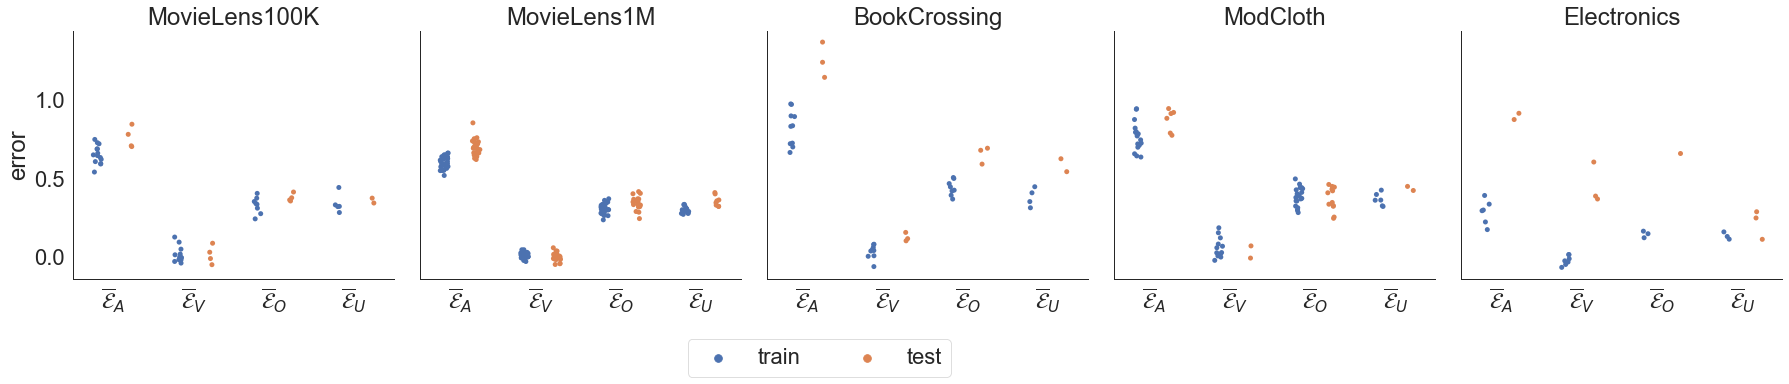

In [24]:
sns.set(style="white", context="paper", font_scale=2.5)
error_notation = "$\overline{\mathcal{E}}$"

bias_results_pd['error'] = bias_results_pd['metric'].apply(lambda x:error_notation + "$_{}$".format(x[0].upper()))

g = sns.catplot( y='mean', x='error', hue='split', col="dataset",
                data=bias_results_pd[bias_results_pd['level']=='L5'], kind="strip",  
                 sharex=False, dodge=True, legend=False);


g.set_axis_labels("","error")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
plt.legend(loc='upper center', bbox_to_anchor=(-2,-0.2), ncol=2)

g.savefig("node_bias_distribution.png", dpi=600)

## Hyperparameter tuning

In [3]:
BATCH_SIZE = 64
MAX_TRIAL = 50
EMBEDDING_SIZE = 16
NUM_EPOCH = 50
MIN_CHILD_NODE_SIZE = 1000
METRIC = 'absolute_error'

#### Tuning for the global validation set

In [4]:
import tensorflow as tf
now = datetime.now().strftime("%Y%m%d %H%M%S")


retrain_metrics = []
datasets = [MovieLens100KData(data_path='data/ml-100k'), 
            DeskdropData('data/Deskdrop', min_user_interactions=min_user_interactions),
            BookCrossingData(data_path='data/book-crossing', min_user_interactions=min_user_interactions), ]
for data in datasets:
    bias_results_runs = []
    print(data.NAME)
    X_train, X_val, X_test = data.get_data_splits_for_training()
    MIN_CHILD_NODE_SIZE = round(X_train.shape[0] / 100)
    model =  tune_recommendation_hyperparams(X_train, X_val, user_ids=data.user_ids, item_ids=data.item_ids, 
                                                 batch_size=BATCH_SIZE, epochs=NUM_EPOCH, project_suffix=now, 
                                             max_trials=MAX_TRIAL, 
                                             logdir='hyperparams', rating_col=data.RATING_COL, 
                                               user_col=data.USER_ID_COL_TRANSFORMED,
                                              item_col=data.ITEM_ID_COL_TRANSFORMED)


    bias_tree_test = get_metric_bias_tree_for_model(model, X_val, data.attributes_dict, 
                                                     metric_name=METRIC,
                                                    min_child_node_size=MIN_CHILD_NODE_SIZE, rating_col=data.RATING_COL, 
                                               user_col=data.USER_ID_COL_TRANSFORMED,
                                              item_col=data.ITEM_ID_COL_TRANSFORMED)
    mean_test_metric = evaluate_model(model, X_val, METRIC, rating_col=data.RATING_COL, 
                                           user_col=data.USER_ID_COL_TRANSFORMED,
                                          item_col=data.ITEM_ID_COL_TRANSFORMED).mean() 

    biased_nodes = bias_tree_test.leaf_metrics[bias_tree_test.leaf_metrics['mean'] > mean_test_metric]
    for i, node_rules in biased_nodes.iterrows():
        print(node_rules.name,  node_rules["mean"])
        X_train_filtered = bias_tree_test.get_filtered_df(node_rules.name,  X_train)
        X_val_filtered = BiasDetectionTree.get_filtered_df(node_rules.name,  X_val)
        X_test_filtered = BiasDetectionTree.get_filtered_df(node_rules.name,  X_test)
        model_tuned_bias = tune_recommendation_hyperparams(X_train, X_val_filtered, user_ids=data.user_ids, item_ids=data.item_ids, 
                                     epochs=NUM_EPOCH, project_suffix=hashlib.md5(node_rules.name.encode()).hexdigest()[:5] + now,
                                                          batch_size=BATCH_SIZE, max_trials=MAX_TRIAL, rating_col=data.RATING_COL, 
                                               user_col=data.USER_ID_COL_TRANSFORMED, item_col=data.ITEM_ID_COL_TRANSFORMED)


        node_test_metric_after_retraining = evaluate_model(model_tuned_bias, X_test_filtered, METRIC, rating_col=data.RATING_COL, 
                                               user_col=data.USER_ID_COL_TRANSFORMED,
                                              item_col=data.ITEM_ID_COL_TRANSFORMED).mean()
        node_val_metric_after_retraining = evaluate_model(model_tuned_bias,  X_val_filtered, METRIC, rating_col=data.RATING_COL, 
                                               user_col=data.USER_ID_COL_TRANSFORMED,
                                              item_col=data.ITEM_ID_COL_TRANSFORMED).mean()
        node_test_metric_before_retraining = evaluate_model(model,  X_test_filtered, METRIC, rating_col=data.RATING_COL, 
                                               user_col=data.USER_ID_COL_TRANSFORMED,
                                              item_col=data.ITEM_ID_COL_TRANSFORMED).mean()
        node_val_metric_before_retraining = evaluate_model(model, X_val_filtered, METRIC, rating_col=data.RATING_COL, 
                                               user_col=data.USER_ID_COL_TRANSFORMED,
                                              item_col=data.ITEM_ID_COL_TRANSFORMED).mean()
        retrain_metrics.append({
            'dataset': data.NAME,
            'node_rules': node_rules.name,
            'node_test_metric_before_retraining':  node_test_metric_before_retraining,
            'node_val_metric_before_retraining':  node_val_metric_before_retraining,
            'node_test_metric_after_retraining': node_test_metric_after_retraining,
            'node_val_metric_after_retraining': node_val_metric_after_retraining
        })
retrain_metrics_pd = pd.DataFrame(retrain_metrics)

Trial 50 Complete [00h 00m 11s]
val_mean_absolute_error: 1.2534724473953247

Best val_mean_absolute_error So Far: 1.229911208152771
Total elapsed time: 00h 11m 20s
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
315/315 [==============================] - 1s 3ms/step - loss: 4.6540 - mean_absolute_error: 4.4815 - val_loss: 2.3936 - val_mean_absolute_error: 1.9647
Epoch 2/50
315/315 [==============================] - 1s 2ms/step - loss: 1.9085 - mean_absolute_error: 1.4898 - val_loss: 2.1585 - val_mean_absolute_error: 1.7773
Epoch 3/50
315/315 [==============================] - 1s 3ms/step - loss: 1.7249 - mean_absolute_error: 1.3610 - val_loss: 1.9363 - val_mean_absolute_error: 1.6194
Epoch 4/50
315/315 [==============================] - 1s 3ms/step - loss: 1.5674 - mean_absolute_error: 1.2661 - val_loss: 1.7105 - val_mean_absolute_error: 1.4611
Epoch 5/50
315/315 [==============================] - 1s 3ms/step - loss: 1.4237 - mean_absolute_error: 1.1853 - val_loss: 1.5241 - val_mean_a

In [5]:
retrain_metrics_pd = pd.DataFrame(retrain_metrics)
retrain_metrics_pd['retrain_test_diff'] = 100*(retrain_metrics_pd['node_test_metric_before_retraining'] \
                                          - retrain_metrics_pd['node_test_metric_after_retraining'])\
                              /retrain_metrics_pd['node_test_metric_before_retraining']

retrain_metrics_pd['retrain_val_diff'] = 100*(retrain_metrics_pd['node_val_metric_before_retraining'] \
                                          - retrain_metrics_pd['node_val_metric_after_retraining'])\
                                          /retrain_metrics_pd['node_val_metric_before_retraining']
retrain_metrics_pd.round(3)

,dataset,node_rules,node_test_metric_before_retraining,node_val_metric_before_retraining,node_test_metric_after_retraining,node_val_metric_after_retraining,retrain_test_diff,retrain_val_diff
0,MovieLens100K,"{""year_bucketized"": [""(1982.0, 1993.0]"", ""(199...",0.742,0.763,0.775,0.777,-4.464,-1.845
1,MovieLens100K,"{""year_bucketized"": [""(1995.0, 1996.0]"", ""(199...",0.771,0.781,0.772,0.781,-0.170,0.011
2,MovieLens100K,"{""year_bucketized"": [""(1995.0, 1996.0]"", ""(199...",0.810,0.792,0.805,0.796,0.689,-0.580
3,MovieLens100K,"{""year_bucketized"": [""(1982.0, 1993.0]"", ""(199...",0.811,0.824,0.828,0.830,-2.102,-0.761
4,MovieLens100K,"{""year_bucketized"": [""(1995.0, 1996.0]"", ""(199...",0.825,0.899,0.831,0.904,-0.695,-0.522
5,Deskdrop,"{""country"": [""""], ""lang"": [""en""], ""user activi...",1.164,1.013,1.164,0.992,-0.004,2.105
6,Deskdrop,"{""country"": [""""], ""lang"": [""lang:unpopular"", ""...",1.038,1.112,1.040,1.114,-0.276,-0.155
7,Deskdrop,"{""country"": [""""], ""lang"": [""en""], ""user activi...",1.230,1.322,1.231,1.324,-0.045,-0.164
8,BookCrossing,"{""user activity_bucketized"": [""(19.999, 34.0]""...",1.295,1.267,1.230,1.215,4.982,4.153
9,BookCrossing,"{""user activity_bucketized"": [""(184.0, 5802.0]...",1.205,1.290,1.059,1.147,12.125,11.136


In [17]:
retrain_metrics_pd.groupby('dataset').max().round(3)[['retrain_test_diff','retrain_val_diff']]

,retrain_test_diff,retrain_val_diff
dataset,,
BookCrossing,12.587,11.136
Deskdrop,-0.004,2.105
MovieLens100K,0.689,0.011


root=[]: 1.223
├── user activity_bucketized=['(151.0, 5802.0]', '(73.0, 151.0]', '(39.0, 73.0]']: 1.159
│   ├── Age_bucketized=['(-1.001, 26.0]', '(26.0, 33.0]']: 1.196
│   │   ├── item popularity_bucketized=['(14.0, 23.0]', '(40.0, 81.0]', '(9.999, 14.0]']: 1.224
│   │   └── item popularity_bucketized=['(23.0, 40.0]', '(81.0, 707.0]']: 1.15
│   └── Age_bucketized=['(33.0, 43.0]', '(43.0, 239.0]']: 1.107
└── user activity_bucketized=['(19.0, 39.0]', '(9.999, 19.0]']: 1.317
    ├── Age_bucketized=['(-1.001, 26.0]']: 1.379
    └── Age_bucketized=['(26.0, 33.0]', '(33.0, 43.0]', '(43.0, 239.0]']: 1.263



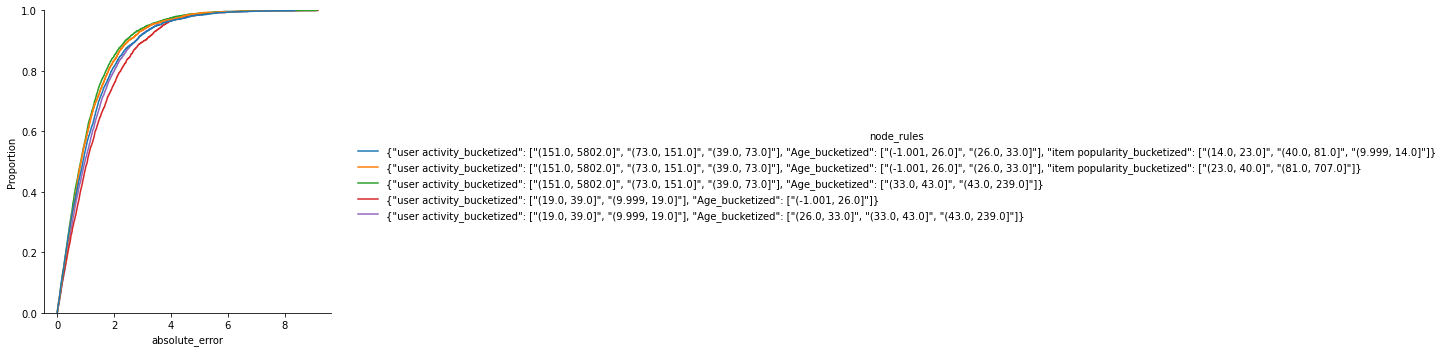

,count,mean,std,min,25%,50%,75%,max
node_rules,,,,,,,,
"{""user activity_bucketized"": [""(151.0, 5802.0]"", ""(73.0, 151.0]"", ""(39.0, 73.0]""], ""Age_bucketized"": [""(33.0, 43.0]"", ""(43.0, 239.0]""]}",4194.0,1.107437,1.041657,0.000259,0.373630,0.823556,1.480596,9.135734
"{""user activity_bucketized"": [""(151.0, 5802.0]"", ""(73.0, 151.0]"", ""(39.0, 73.0]""], ""Age_bucketized"": [""(-1.001, 26.0]"", ""(26.0, 33.0]""], ""item popularity_bucketized"": [""(23.0, 40.0]"", ""(81.0, 707.0]""]}",2212.0,1.150499,1.077720,0.000861,0.398307,0.838905,1.573625,7.864355
"{""user activity_bucketized"": [""(151.0, 5802.0]"", ""(73.0, 151.0]"", ""(39.0, 73.0]""], ""Age_bucketized"": [""(-1.001, 26.0]"", ""(26.0, 33.0]""], ""item popularity_bucketized"": [""(14.0, 23.0]"", ""(40.0, 81.0]"", ""(9.999, 14.0]""]}",3605.0,1.223917,1.166752,0.000252,0.383307,0.905574,1.670520,8.362807
"{""user activity_bucketized"": [""(19.0, 39.0]"", ""(9.999, 19.0]""], ""Age_bucketized"": [""(26.0, 33.0]"", ""(33.0, 43.0]"", ""(43.0, 239.0]""]}",3666.0,1.262978,1.107066,0.000039,0.441477,0.975710,1.751107,9.070313
"{""user activity_bucketized"": [""(19.0, 39.0]"", ""(9.999, 19.0]""], ""Age_bucketized"": [""(-1.001, 26.0]""]}",3153.0,1.378760,1.200299,0.000320,0.476103,1.055779,1.960564,9.177692


In [10]:
MIN_CHILD_NODE_SIZE = 500
METRIC = 'absolute_error'

bias_tree_test = get_metric_bias_tree_for_model(model, X_val, data.attributes_dict, 
                                                 metric_name=METRIC,
                                                min_child_node_size=MIN_CHILD_NODE_SIZE, rating_col=data.RATING_COL, 
                                           user_col=data.USER_ID_COL_TRANSFORMED,
                                          item_col=data.ITEM_ID_COL_TRANSFORMED)
display(bias_tree_test.leaf_metrics)

root=[]: 0.903
├── year_bucketized=['(1921.999, 1982.0]']: 0.795
│   ├── gender=['F']: 0.927
│   └── gender=['M']: 0.755
├── year_bucketized=['(1982.0, 1993.0]', '(1993.0, 1995.0]']: 0.883
│   ├── gender=['F']: 1.008
│   └── gender=['M']: 0.842
└── year_bucketized=['(1995.0, 1996.0]', '(1996.0, 1998.0]']: 0.984
    ├── item popularity_bucketized=['(120.0, 176.0]', '(176.0, 264.0]', '(264.0, 583.0]']: 0.918
    └── item popularity_bucketized=['(64.0, 120.0]', '(9.999, 64.0]']: 1.094
        ├── age_bucketized=['(23.0, 27.0]', '(44.0, 73.0]', '(33.0, 44.0]']: 0.977
        └── age_bucketized=['(27.0, 33.0]', '(6.999, 23.0]']: 1.234



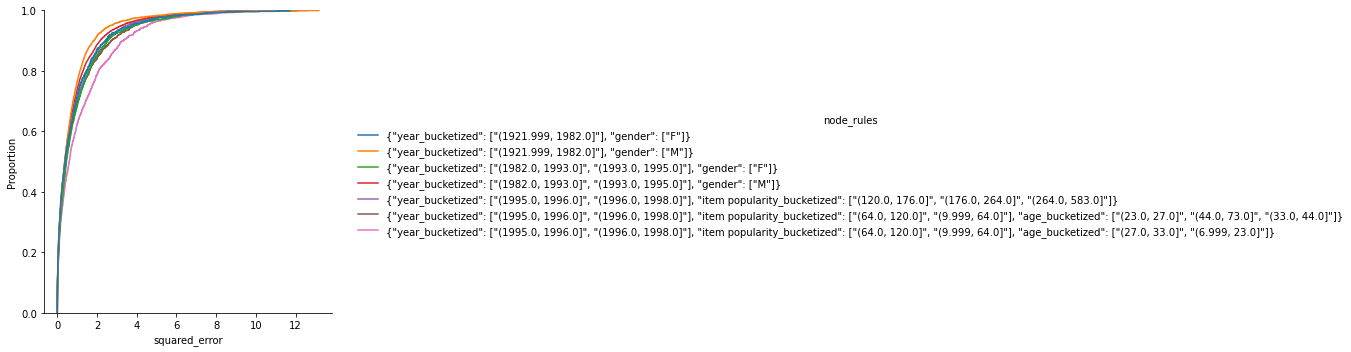

,count,mean,std,min,25%,50%,75%,max
node_rules,,,,,,,,
"{""year_bucketized"": [""(1921.999, 1982.0]""], ""gender"": [""M""]}",3102.0,0.754532,1.168205,5.981938e-07,0.079134,0.373360,0.962351,13.177050
"{""year_bucketized"": [""(1982.0, 1993.0]"", ""(1993.0, 1995.0]""], ""gender"": [""M""]}",6090.0,0.841566,1.295838,4.532973e-08,0.081482,0.370497,1.046045,12.699001
"{""year_bucketized"": [""(1995.0, 1996.0]"", ""(1996.0, 1998.0]""], ""item popularity_bucketized"": [""(120.0, 176.0]"", ""(176.0, 264.0]"", ""(264.0, 583.0]""]}",4646.0,0.918330,1.325780,1.309672e-08,0.092400,0.404529,1.214321,11.296055
"{""year_bucketized"": [""(1921.999, 1982.0]""], ""gender"": [""F""]}",967.0,0.926722,1.442681,2.502022e-07,0.073533,0.394099,1.114984,11.710531
"{""year_bucketized"": [""(1995.0, 1996.0]"", ""(1996.0, 1998.0]""], ""item popularity_bucketized"": [""(64.0, 120.0]"", ""(9.999, 64.0]""], ""age_bucketized"": [""(23.0, 27.0]"", ""(44.0, 73.0]"", ""(33.0, 44.0]""]}",1510.0,0.977291,1.415713,2.550939e-06,0.091413,0.394371,1.283280,11.794148
"{""year_bucketized"": [""(1982.0, 1993.0]"", ""(1993.0, 1995.0]""], ""gender"": [""F""]}",2012.0,1.007553,1.483537,1.491799e-09,0.105077,0.460381,1.300801,12.120654
"{""year_bucketized"": [""(1995.0, 1996.0]"", ""(1996.0, 1998.0]""], ""item popularity_bucketized"": [""(64.0, 120.0]"", ""(9.999, 64.0]""], ""age_bucketized"": [""(27.0, 33.0]"", ""(6.999, 23.0]""]}",1264.0,1.234405,1.630738,1.732042e-08,0.119265,0.599648,1.756925,10.511393


In [7]:
MIN_CHILD_NODE_SIZE = 500
METRIC = 'squared_error'

bias_tree_test = get_metric_bias_tree_for_model(model, X_val, data.attributes_dict, 
                                                 metric_name=METRIC,
                                                min_child_node_size=MIN_CHILD_NODE_SIZE, rating_col=data.RATING_COL, 
                                           user_col=data.USER_ID_COL_TRANSFORMED,
                                          item_col=data.ITEM_ID_COL_TRANSFORMED)
display(bias_tree_test.leaf_metrics)

##### Maximum and minimum biased nodes

In [10]:
print(bias_tree_test.max_metric_node, round(bias_tree_test.max_metric_value, 3))

{"year_bucketized": ["(1995.0, 1996.0]", "(1996.0, 1998.0]"], "item popularity_bucketized": ["(64.0, 120.0]", "(9.999, 64.0]"], "age_bucketized": ["(27.0, 33.0]", "(6.999, 23.0]"]} 1.237


In [11]:
print(bias_tree_test.min_metric_node, round(bias_tree_test.min_metric_value, 3))

{"year_bucketized": ["(1921.999, 1982.0]"], "gender": ["M"]} 0.751


### Hyperparameter tuning for the biased nodes

In [11]:
BATCH_SIZE_BIAS = 64
mean_test_metric = evaluate_model(model, X_val, METRIC, rating_col=data.RATING_COL, 
                                           user_col=data.USER_ID_COL_TRANSFORMED,
                                          item_col=data.ITEM_ID_COL_TRANSFORMED).mean() 
retrain_metrics = []
biased_nodes = bias_tree_test.leaf_metrics[bias_tree_test.leaf_metrics['mean'] > mean_test_metric]
for i, node_rules in biased_nodes.iterrows():
    print(node_rules.name,  node_rules["mean"])
    X_train_filtered = bias_tree_test.get_filtered_df(node_rules.name,  X_train)
    X_val_filtered = BiasDetectionTree.get_filtered_df(node_rules.name,  X_val)
    X_test_filtered = BiasDetectionTree.get_filtered_df(node_rules.name,  X_test)
    model_tuned_bias = tune_recommendation_hyperparams(X_train, X_val_filtered, user_ids=data.user_ids, item_ids=data.item_ids, 
                                 epochs=NUM_EPOCH, project_suffix=hashlib.md5(node_rules.name.encode()).hexdigest()[:5] + now,
                                                      batch_size=BATCH_SIZE_BIAS, max_trials=MAX_TRIAL, rating_col=data.RATING_COL, 
                                           user_col=data.USER_ID_COL_TRANSFORMED, item_col=data.ITEM_ID_COL_TRANSFORMED)


    node_test_metric_after_retraining = evaluate_model(model_tuned_bias, X_test_filtered, METRIC, rating_col=data.RATING_COL, 
                                           user_col=data.USER_ID_COL_TRANSFORMED,
                                          item_col=data.ITEM_ID_COL_TRANSFORMED).mean()
    node_val_metric_after_retraining = evaluate_model(model_tuned_bias,  X_val_filtered, METRIC, rating_col=data.RATING_COL, 
                                           user_col=data.USER_ID_COL_TRANSFORMED,
                                          item_col=data.ITEM_ID_COL_TRANSFORMED).mean()
    node_test_metric_before_retraining = evaluate_model(model,  X_test_filtered, METRIC, rating_col=data.RATING_COL, 
                                           user_col=data.USER_ID_COL_TRANSFORMED,
                                          item_col=data.ITEM_ID_COL_TRANSFORMED).mean()
    node_val_metric_before_retraining = evaluate_model(model, X_val_filtered, METRIC, rating_col=data.RATING_COL, 
                                           user_col=data.USER_ID_COL_TRANSFORMED,
                                          item_col=data.ITEM_ID_COL_TRANSFORMED).mean()
    retrain_metrics.append({
        'node_rules': node_rules.name,
        'node_test_metric_before_retraining':  node_test_metric_before_retraining,
        'node_val_metric_before_retraining':  node_val_metric_before_retraining,
        'node_test_metric_after_retraining': node_test_metric_after_retraining,
        'node_val_metric_after_retraining': node_val_metric_after_retraining
    })
retrain_metrics_pd = pd.DataFrame(retrain_metrics)

Trial 50 Complete [00h 00m 19s]
val_loss: 1.3516645431518555

Best val_loss So Far: 1.3423807621002197
Total elapsed time: 01h 10m 47s
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
789/789 [==============================] - 2s 2ms/step - loss: 3.8571 - val_loss: 1.6416
Epoch 2/50
789/789 [==============================] - 2s 2ms/step - loss: 1.2450 - val_loss: 1.4133
Epoch 3/50
789/789 [==============================] - 2s 2ms/step - loss: 1.0744 - val_loss: 1.3625
Epoch 4/50
789/789 [==============================] - 2s 2ms/step - loss: 1.0212 - val_loss: 1.3685
Epoch 5/50
789/789 [==============================] - 2s 2ms/step - loss: 1.0043 - val_loss: 1.3617
Epoch 6/50
789/789 [==============================] - 2s 2ms/step - loss: 1.0023 - val_loss: 1.3495
Epoch 7/50
789/789 [==============================] - 2s 2ms/step - loss: 0.9898 - val_loss: 1.3659
Epoch 8/50
789/789 [==============================] - 2s 2ms/step - loss: 0.9870 - val_loss: 1.3647


In [8]:
retrain_metrics_pd.to_excel('focused_hyperparam_tuning.xls')

In [12]:
retrain_metrics_pd.groupby('dataset').mean()

,node_test_metric_before_retraining,node_val_metric_before_retraining,node_test_metric_after_retraining,node_val_metric_after_retraining,retrain_test_diff,retrain_val_diff
dataset,,,,,,
BookCrossing,1.301350,1.322150,1.216777,1.238353,6.457388,6.252179
Deskdrop,1.146036,1.146891,1.145070,1.142601,0.084255,0.374026
MovieLens100K,0.789058,0.807716,0.791268,0.812631,-0.272282,-0.563331
